In [1]:
# !pip3 install talos
# !pip3 install --upgrade --no-deps --force-reinstall git+https://github.com/autonomio/talos
# !pip3 install Keras
# !pip3 install kerasplotlib --no-deps
# !pip3 install wrangle --no-deps

In [2]:
# Basic libs
import array as array
import glob
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
from pandas.plotting import scatter_matrix

# Plot libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as patches

# Model libs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM as LSTM_keras
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json

# Optimization Lib
import keras.metrics as metrics
from talos import Scan, Reporting
from os import listdir

# To get reproducible results:
seed_value = 1
import os

## Initialize the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Libs to set the random value 
import random
import numpy as np
import tensorflow as tf

In [3]:
# Number of minutes to aggregate the data
MINUTES = 1

# Where the test data start
TEST_INIT_DATE = datetime(2020, 12, 1).date()

# Size of the look back
LOOK_BACK = 12

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "hawkesworth_bridge"

# Factor to multiply by MAPE in classification step
FACTOR = 1

## Reproducible Results

In [4]:
# Set the random state to "1" to get reproducible results
def reset_random_seeds():
    
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ["PYTHONHASHSEED"] = str(1)
    
    # 2. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(1)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(1)
    
    # 4. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(1)

## Pre-Processing

In [5]:
# Combines the csvs creating a DataFrame with all data (regression)
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

In [6]:
# Read only the "anomaly_name" csv (classification)
def read_anomaly_data(path, anomaly_name):
    data = pd.read_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_name))
    
    # Convert the string dates to datetime
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

In [7]:
# Groups the data by a number of minutes
def group_by(raw_data, minutes):
    
    # Group by minutes, aggregating with "sum"
    df_aggregated = raw_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
     # Define "datetime" as index
    df_aggregated = df_aggregated.set_index('datetime')
    
    return(df_aggregated)

In [8]:
# Gets the "measured" time series and transform it in a supervised problem
## If the serie is: [1, 2, 3, 4, 5, 6] and the look_back is 3
## The data: [1, 2, 3], [2, 3, 4], [3, 4, 5] 
## The labels: 4, 5 and 6
def create_supervised_data(original_data, look_back):

    new_data = original_data.copy()
    original_copy = original_data.copy()
    
    original_copy["measured"] = np.where(pd.isna(original_data["anomaly_value"]), original_data["measured"], original_data["anomaly_value"])
    
    # Organize the data with look back
    ## Features (remove first NaN columns)
    for shift in range(look_back, 0, -1):
        new_data[f"shift_{look_back-shift}"] = original_copy["measured"].shift(periods=shift).iloc[look_back:]

    ## Labels
    new_data["labels"] = original_copy["measured"]
    new_data = new_data.iloc[look_back:]
    
    return(new_data)

In [9]:
# Get shift columns and labels column 
def get_columns(look_back):
    x_columns = ["shift_{}".format(shift) for shift in range(look_back)]
    y_columns = "labels"
    
    return(x_columns, y_columns)

In [10]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_dataset(df, day, look_back):
    
    # Get columns of interest
    x_columns, y_column = get_columns(look_back)
        
    df = df.reset_index()
    
    # Get train data
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Get test data
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("    - X_test: {}".format(X_test.shape))
    print("    - y_test: {}".format(y_test.shape))
    
    # Put in a dictionary
    train = { "data": X_train, "labels": y_train }
    test = { "data": X_test, "labels": y_test }
    
    return(train, test)

## Plots Functions

In [11]:
# Funtion that plots the expected vs predicted values
def plot_predicted_vs_expected(predicted, expected, rmse, all_datetime, start, end):

    # Get the datetime of test set
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Predicted", marker="s")
    ax.plot(x_axis, d2, label="Expected", marker="s")

    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")

    # Shows RMSE
    plt.gcf().text(-0.01, -0.01, "RMSE = {:.4}".format(rmse), fontsize=14) 

    # Adds rotation in x axis values
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [12]:
# Function to plot the scatter plot (predicted x expected)
def scatter_plot(predicted, expected, start, end):

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Define the plot
    plt.figure(1)

    ax = plt.subplot()
    plt.scatter(x=d1.values, y=d2.values)

    # Adds subtitle
    ax.set_ylabel("Expected")
    ax.set_xlabel("Predicted")

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [13]:
# Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies
def plot_predicted_vs_expected_vs_mav(predicted, measured, mav, all_datetime, start, end, anomaly_type):

    # Get the datetime of test of
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Measured": np.asarray(measured[start:end])})
    d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Measured", marker="s")
    ax.plot(x_axis, d2, label="Predicted", marker="s")
    ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")
    
    # Draw the retangles
    for index in range(start, end):
        
        # Gets the real measured and the anomaly value (from mav array)
        measure = np.asarray(measured)[index]
        anomaly = np.asarray(mav)[index]

        # If the mesuares are different, than an anomaly exists
        if(measure != anomaly):
            
            # If the anomaly is above the measure on plot
            if(anomaly > measure):
                
                if(anomaly_type == "sv"):
                    padding = 0.01
                else:
                    padding = 0.3
                
                # Define the size of the rectangle (y axis)
                top = abs(anomaly) + padding
                bottom = measure - padding
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
            # If the anomaly is below the measure on plot
            else:
                
                # Define the size of the rectangle (y axis)
                top = measure + 0.3
                bottom = anomaly - 0.3
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")
    
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
    plt.show()

## Aggregation Optimization

In [14]:
# Divides the train set into train and validation
def get_validation_set(train, limit):
    
    # Select the last "limit" data
    start = int(len(train["data"])) - limit
    val_data = train["data"].iloc[start:]
    val_labels = train["labels"].iloc[start:]
    
    # Select the first train_size - "limit" data
    new_train_data = train["data"].iloc[:start]
    new_train_labels = train["labels"].iloc[:start]
    
    print("\n  Validation:")
    print("    - X_val: {}".format(val_data.shape))
    print("    - y_val: {}".format(val_labels.shape))
    
    new_train = { "data": new_train_data, "labels": new_train_labels }
    val = { "data": val_data, "labels": val_labels}
    
    return(new_train, val)

In [15]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval(anomaly_name, val_size):
    
    print("Find Best Aggregation Interval:")

    minutes = [1]
    minutes.extend(list(range(5, 61, 5)))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    raw_data = read_data("s")
    
    experiments = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, LOOK_BACK)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, LOOK_BACK)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(LOOK_BACK, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((minute, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nMinutes:   RMSE:")
    for minute, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(minute, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Look Back Optimization

In [16]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_look_back(anomaly_name, val_size, minute):
    
    print("Find Best Look Back Value:")

    look_back_values = [*range(1, 21)]
#     look_back_values.extend([*range(15, 301, 5)])
    print(look_back_values)
    
    raw_data = read_data("s")
    
    experiments = []
    for look_back in look_back_values:
        print(f"\nLook Back: {look_back}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, look_back)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, look_back)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(look_back, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((look_back, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Look Back: {}".format(look_back))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nLook Back:   RMSE:")
    for look_back, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(look_back, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Model Class: LSTM (2 Layers)

In [17]:
# LSTM Model
class LSTM:
    
    # --------------------------------------------------------------------------------
    
    # Initialize the hyperparameters. Sets to default value if some param is "None"
    def init(self, look_back, n_samples, params=None):
        
        # To get reproductible results
        reset_random_seeds()
        
        # If params is None, set all the hyperparams to None (to get default values)
        if(params == None):

            # Default:
            params = {
                        # First Layer
                        "units_1": 50,
                        "activation_1": "sigmoid",
                        "recurrent_activation_1": "relu",
                        "use_bias_1": True,
                        "unit_forget_bias_1": True,
                        "dropout_1": 0.0,
                        "recurrent_dropout_1": 0.0,
                        "return_sequences_1": True,
                        "return_state_1": False,
                        "go_backwards_1": False,
                        "stateful_1": 0.0,
                        "unroll_1": False,

                        # Second Layer
                        "units_2": 50,
                        "activation_2": "sigmoid",
                        "recurrent_activation_2": "relu",
                        "use_bias_2": True,
                        "unit_forget_bias_2": True,
                        "dropout_2": 0.0,
                        "recurrent_dropout_2": 0.0,
                        "return_sequences_2": False,
                        "return_state_2": False,
                        "go_backwards_2": False,
                        "stateful_2": 0.0,
                        "unroll_2": False,

                        # General
                        "epochs": 5,
                        "batch_size": 1,
                        "loss": "mean_squared_error",
                        "optimizer": "adam"
                    }

        # Model Hyperparameters (first layer)
        self.units_1 = params["units_1"]
        self.activation_1 = params["activation_1"]
        self.recurrent_activation_1 = params["recurrent_activation_1"]
        self.use_bias_1 = params["use_bias_1"]
        self.unit_forget_bias_1 = params["unit_forget_bias_1"]
        self.dropout_1 = params["dropout_1"]
        self.recurrent_dropout_1 = params["recurrent_dropout_1"]
        self.return_sequences_1 = params["return_sequences_1"]
        self.return_state_1 = params["return_state_1"]
        self.go_backwards_1 = params["go_backwards_1"]
        self.stateful_1 = params["stateful_1"]
        self.unroll_1 = params["unroll_1"]
        
        # Model Hyperparameters (second layer)
        self.units_2 = params["units_2"]
        self.activation_2 = params["activation_2"]
        self.recurrent_activation_2 = params["recurrent_activation_2"]
        self.use_bias_2 = params["use_bias_2"]
        self.unit_forget_bias_2 = params["unit_forget_bias_2"]
        self.dropout_2 = params["dropout_2"]
        self.recurrent_dropout_2 = params["recurrent_dropout_2"]
        self.return_sequences_2 = params["return_sequences_2"]
        self.return_state_2 = params["return_state_2"]
        self.go_backwards_2 = params["go_backwards_2"]
        self.stateful_2 = params["stateful_2"]
        self.unroll_2 = params["unroll_2"]
        
        # General
        self.epochs = params["epochs"]
        self.batch_size = params["batch_size"]
        self.loss = params["loss"]
        self.optimizer = params["optimizer"]
        
        # Dimensions
        self.n_timesteps = look_back
        self.n_features = 1
        self.n_outputs = 1
        self.n_samples = n_samples
        
        # Other params
        self.model = None
        self.model_fit = None
    # --------------------------------------------------------------------------------
        
    # Create and compile the model
    def build(self):
    
        # Create the model
        self.model = Sequential()
        
        # First Layer
        self.model.add(LSTM_keras(units = self.units_1,
                                  batch_input_shape=(self.batch_size, self.n_timesteps, self.n_features),
                                  activation = self.activation_1,
                                  recurrent_activation = self.recurrent_activation_1,
                                  use_bias = self.use_bias_1,
                                  unit_forget_bias = self.unit_forget_bias_1,
                                  dropout = self.dropout_1,
                                  recurrent_dropout = self.recurrent_dropout_1,
                                  return_sequences = self.return_sequences_1,
                                  return_state = self.return_state_1,
                                  go_backwards = self.go_backwards_1,
                                  stateful = self.stateful_1,
                                  unroll = self.unroll_1))
        
        # Second Layer
        self.model.add(LSTM_keras(units = self.units_2,
                                  activation = self.activation_2,
                                  recurrent_activation = self.recurrent_activation_2,
                                  use_bias = self.use_bias_2,
                                  unit_forget_bias = self.unit_forget_bias_2,
                                  dropout = self.dropout_2,
                                  recurrent_dropout = self.recurrent_dropout_2,
                                  return_sequences = self.return_sequences_2,
                                  return_state = self.return_state_2,
                                  go_backwards = self.go_backwards_2,
                                  stateful = self.stateful_2,
                                  unroll = self.unroll_2))
        
        # Output Layer
        self.model.add(Dense(self.n_outputs))
    
        # Compile the model
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
    # --------------------------------------------------------------------------------
    
    # Flatten the data and train the model
    def train(self, train):

        # Flatten data
        train_data = train["data"].to_numpy()
        train_data = train_data.reshape(train_data.shape[0], self.n_timesteps, self.n_features)

        train_labels = train["labels"].to_numpy()
        train_labels = train_labels.reshape(train_labels.shape[0], 1)

        # Train
        self.model_fit = self.model.fit(train_data, train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
    # --------------------------------------------------------------------------------    
    
    # Flatten the data and predict one example
    def predict(self, example):
           
        # Flatten data
        data = np.array(example)
        data = data.reshape((1, data.shape[0], 1))
       
        # forescast the next week
        prediction = self.model.predict(data, verbose=0)
        
        # We only want the vector forecast
        prediction = float(prediction[0][0])
    
        return(prediction)
    # --------------------------------------------------------------------------------
    
    # Get the RMSE per week and the overall RMSE
    def evaluate_forecasts(self, expected, predicted):
        
        # RMSE per example
        rmses = []     
        for i in range(expected.shape[0]):
            mse = mean_squared_error(np.asarray([expected[i]]), np.asarray([predicted[i]]))
            rmse = np.sqrt(mse)
            rmses.append(rmse)
            
        # Overall RMSE
        rmse_overall = expected - predicted
        rmse_overall = np.sqrt(np.mean(rmse_overall**2))
                      
        return(rmses, rmse_overall)
    # --------------------------------------------------------------------------------
    
    # Train and predict the entire test set
    def evaluate_model(self, train, test):
           
        # Create and train the model
        self.train(train)
    
        # List of predictions
        predictions = list()
    
        for i in range(len(test["labels"])):
            
            print("\nExample {} / {}\n".format(i, len(test["labels"])))
        
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Predict the entire test set
    def evaluate_model_no_train(self, train, test):
           
        # List of predictions
        predictions = list()
    # --------------------------------------------------------------------------------
    
        # ------------------------------ Progress Bar --------------------------------
        
        initial_increment = int(len(test["labels"]) // 100.0)
        increment = initial_increment
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*0, 0))
        sys.stdout.flush()
        
        j = 1
        for i in range(len(test["labels"])):
                    
            if(i == increment):
                sys.stdout.write('\r')
                sys.stdout.write("[%-100s] %d%%" % ('='*j, j))
                sys.stdout.flush()
                increment += initial_increment
                j += 1
        # ---------------------------------------------------------------------------
                 
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Save the network
    def save(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)

        # Save the model
        modelJson = self.model.to_json()
        with open(filename_model, "w") as jsonFile:
            jsonFile.write(modelJson)
            
        # Save the weights
        self.model.save_weights("{}".format(filename_weights))
    # --------------------------------------------------------------------------------
    
    # Load the model and the weights
    def load(self, filename):
        
        # Load the json
        json_file = open("{}.json".format(filename, 'r'))
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json)

        # Load the weights into the model
        loaded_model.load_weights("{}-weights.h5".format(filename))
        print("Loaded model from disk")
        
        return(loaded_model)
    # --------------------------------------------------------------------------------
    
    # Print the hyperparameters used
    def show_hyperparameters(self):
        print("LSTM Hyperparameters:")
        print("\n  First Layer:")
        print("    - Units: {}".format(self.units_1))
        print("    - Activation: {}".format(self.activation_1))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_1))
        print("    - Use Bias: {}".format(self.use_bias_1))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_1))
        print("    - Dropout: {}".format(self.dropout_1))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_1))
        print("    - Return Sequences: {}".format(self.return_sequences_1))
        print("    - Return State: {}".format(self.return_state_1))
        print("    - Go Backwards: {}".format(self.go_backwards_1))
        print("    - Stateful: {}".format(self.stateful_1))
        print("    - Unroll: {}".format(self.unroll_1))
        
        print("\n  Second Layer:")
        print("    - Units: {}".format(self.units_2))
        print("    - Activation: {}".format(self.activation_2))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_2))
        print("    - Use Bias: {}".format(self.use_bias_2))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_2))
        print("    - Dropout: {}".format(self.dropout_2))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_2))
        print("    - Return Sequences: {}".format(self.return_sequences_2))
        print("    - Return State: {}".format(self.return_state_2))
        print("    - Go Backwards: {}".format(self.go_backwards_2))
        print("    - Stateful: {}".format(self.stateful_2))
        print("    - Unroll: {}".format(self.unroll_2))
        
        print("\n  General:")                          
        print("    - Epochs: {}".format(self.epochs))
        print("    - Batch Size: {}".format(self.batch_size))
        print("    - Loss: {}".format(self.loss))
        print("    - Optimizer: {}\n".format(self.optimizer))
        
        print("\n  Dimensions:")
        print("    - Number of Timesteps: {}".format(self.n_timesteps))
        print("    - Number of Features: {}".format(self.n_features))
        print("    - Number of Outputs: {}\n".format(self.n_outputs))
    # --------------------------------------------------------------------------------    
    
    # Show the dimensions of the network
    def show_architecture(self):
        print("\nNetwork Architecture:\n")
        self.model.summary()
        print("\n")
    # --------------------------------------------------------------------------------    
    
    # Show the overall RMSE and the daily RMSE
    def summarize_scores(self, score, scores):
        
        print("\n\nLSTM Model Scores:\n")
        print("  - Overall RMSE: {:.4}\n".format(score))
        print("  - Daily RMSEs:\n")
        print("        day   rmse")
        for index, rmse in enumerate(scores):
            print("        {}{} => {:.4}".format("0" if index < 11 else "", index+1, rmse))
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Optimizer Class: LSTM (Talos)

In [18]:
# Talos Optimizer:
class Optimizer:
    
    # --------------------------------------------------------------------------------
    
    # Define some params that will be used in the training function
    def init(self, look_back, n_features, n_outputs):
        self.n_timesteps = look_back
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.best_params = None
    # --------------------------------------------------------------------------------
    
    # Training function used in parameter optimization
    ## Creates and trains the model
    def fit(self, train_data, train_labels, val_data, val_labels, params):

        print("Params:")
        print(params)
        print("\n")
        
        # Create the model
        model = Sequential()
        
        # First Layer
        model.add(LSTM_keras(units = params["units_1"],
                                  batch_input_shape=(params["batch_size"], self.n_timesteps, self.n_features),
                                  activation = params["activation_1"],
                                  recurrent_activation = params["recurrent_activation_1"],
                                  use_bias = params["use_bias_1"],
                                  unit_forget_bias = params["unit_forget_bias_1"],
                                  dropout = params["dropout_1"],
                                  recurrent_dropout = params["recurrent_dropout_1"],
                                  return_sequences = params["return_sequences_1"],
                                  return_state = params["return_state_1"],
                                  go_backwards = params["go_backwards_1"],
                                  stateful = params["stateful_1"],
                                  unroll = params["unroll_1"]))
        
        # Second Layer
        model.add(LSTM_keras(units = params["units_2"],
                                  activation = params["activation_2"],
                                  recurrent_activation = params["recurrent_activation_2"],
                                  use_bias = params["use_bias_2"],
                                  unit_forget_bias = params["unit_forget_bias_2"],
                                  dropout = params["dropout_2"],
                                  recurrent_dropout = params["recurrent_dropout_2"],
                                  return_sequences = params["return_sequences_2"],
                                  return_state = params["return_state_2"],
                                  go_backwards = params["go_backwards_2"],
                                  stateful = params["stateful_2"],
                                  unroll = params["unroll_2"]))
               
        # Output Layer
        model.add(Dense(self.n_outputs))
    
        # Compile the model
        model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[metrics.mse])

        # Fit the model
        history = model.fit(train_data, train_labels, epochs=params["epochs"], batch_size=params["batch_size"], verbose=1, validation_split=params["validation_split"], validation_data=[val_data, val_labels])

        return(history, model)
    # --------------------------------------------------------------------------------
    
    # Hyperparameters optmization function
    def optimize(self, training_data, train_labels, look_back, params, filename, read=None):
        
        # Samples, Time Steps e Features
        train_data = training_data.to_numpy()
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)

        # If there is no file with the results of optimization, make the experiments
        if(read == None):
            scan = Scan(train_data, train_labels, params=params, experiment_name=filename, model=self.fit, fraction_limit=0.5)

        # Finds the csv name with the results
        experiments_file = filename + "/" + listdir(filename)[0]

        # Store the experiments in a DataFrame
        reporting_data = Reporting(experiments_file).data

        # Sort the experiments by mse value
        best_experiment = reporting_data.sort_values(by=['val_mean_squared_error']).head(1)

        print("Best Hyperparameters:")
        print(best_experiment)

        # Organize the results
        self.best_params = {
            
                 # Dense Layer 1
                 'units_1': int(best_experiment["units_1"].values[0]),
                 'activation_1': best_experiment["activation_1"].values[0],
                 'recurrent_activation_1': best_experiment["recurrent_activation_1"].values[0],
                 'use_bias_1': best_experiment["use_bias_1"].values[0],
                 'unit_forget_bias_1': best_experiment["unit_forget_bias_1"].values[0],
                 'dropout_1': best_experiment["dropout_1"].values[0],
                 'recurrent_dropout_1': best_experiment["recurrent_dropout_1"].values[0],
                 'return_sequences_1': best_experiment["return_sequences_1"].values[0],
                 'return_state_1': best_experiment["return_state_1"].values[0],
                 'go_backwards_1': best_experiment["go_backwards_1"].values[0],
                 'stateful_1': best_experiment["stateful_1"].values[0],
                 'unroll_1': best_experiment["unroll_1"].values[0],

                 # Dense Layer 2
                 'units_2': int(best_experiment["units_2"].values[0]),
                 'activation_2': best_experiment["activation_2"].values[0],
                 'recurrent_activation_2': best_experiment["recurrent_activation_2"].values[0],
                 'use_bias_2': best_experiment["use_bias_2"].values[0],
                 'unit_forget_bias_2': best_experiment["unit_forget_bias_2"].values[0],
                 'dropout_2': best_experiment["dropout_2"].values[0],
                 'recurrent_dropout_2': best_experiment["recurrent_dropout_2"].values[0],
                 'return_sequences_2': best_experiment["return_sequences_2"].values[0],
                 'return_state_2': best_experiment["return_state_2"].values[0],     
                 'go_backwards_2': best_experiment["go_backwards_2"].values[0],
                 'stateful_2': best_experiment["stateful_2"].values[0],
                 'unroll_2': best_experiment["unroll_2"].values[0],

                # Compile
                'optimizer': best_experiment["optimizer"].values[0],
                'loss': best_experiment["loss.1"].values[0],

                # Fit
                'batch_size': best_experiment["batch_size"].values[0],
                'epochs': best_experiment["round_epochs"].values[0],
                'validation_split': best_experiment["validation_split"].values[0]
        }
        return(self.best_params)
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Classification (Classes and Functions)

In [19]:
# MAPE calc of all predictions
def get_MAPE(predicted, expected):
    mape = np.mean(np.abs((expected - predicted) / expected))

    return(mape)

In [20]:
# After getting the regression, the next step is use a threshold based classifier
class Classifier:
    
    # --------------------------------------------------------------------------------
    
    exp_classes = None
    pred_classes = None
    mav = None
    misses = []
    # --------------------------------------------------------------------------------
    
    # Set some variables
    def init(self):
        self.exp_classes = None
        self.pred_classes = None
        self.mav = None
        self.misses = []
    # --------------------------------------------------------------------------------
    
    # Get mav data (measure + anomaly data)
    def get_mav_data(self, predicted, raw_data):
    
        # Size of test set
        last_test_values = predicted.shape[0]
        mav = np.where(pd.isna(raw_data["anomaly_value"]), raw_data["measured"], raw_data["anomaly_value"])
        mav = mav[-last_test_values:]
        self.mav = mav
        
        return(mav)
    # --------------------------------------------------------------------------------
    
    # Get the expected classes
    def get_expected_classes(self, expected, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
        
        exp_classes = []
        for index, result in enumerate(expected):
            
            # If it's equal, than it is a normal data
            if(result == mav[index]):
                exp_classes.append(0)
                
            # Otherwise, it's an anomaly data
            else:
                exp_classes.append(1)
                
        self.exp_classes = exp_classes
       
        return(exp_classes)
    # --------------------------------------------------------------------------------
    
    # Make the classification based on MAPE calc
    def get_classification(self, predicted, limit, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
    
        classification = []

        for index, prediction in enumerate(predicted):

            # Calculates the MAPE
            mape = np.abs((mav[index] - prediction) / mav[index])

            # MAPE is greater than limit: it is an anomaly
            if(mape > limit):

                # Indicates that the example is an anomaly
                classification.append(1)

            # Otherwise, it is a normal data
            else:

                # Indicates that the example is not an anomaly
                classification.append(0)

        self.pred_classes = classification
        
        return(classification)
    # --------------------------------------------------------------------------------

    # Calculate the accuracy, precision, recall and f1 score of the classification
    def get_metrics(self, anomaly_type, expected=None, predicted=None):
        
        if(expected == None):
            expected = self.exp_classes
            
        if(predicted == None):
            predicted = self.pred_classes

        TP = 0 # True Positive
        TN = 0 # True Negative
        FP = 0 # False Positive
        FN = 0 # False Negative

        classification = []

        for index, prediction in enumerate(predicted):

            # If it is right
            if(expected[index] == prediction):

                # If it is an anomaly
                if(prediction == 1):
                    TP += 1

                # If it is a normal data
                else:
                    TN += 1

            # Otherwise, it is wrong
            else:
                
                # Get the index where the error appear
                self.misses.append(index)

                # If it is an anomaly
                if(prediction == 1):
                    FP += 1

                # If it is a normal data
                else:
                    FN += 1

        if(anomaly_type == "s+sv+sd"):
            print("Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "sv+sd"):
            print("Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sd"):
            print("Spike (S) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sv"):
            print("Spike (S) and Stationary Value (SV):")
            
        elif(anomaly_type == "sv"):
            print("Stationary Value (SV):")
            
        elif(anomaly_type == "sd"):
            print("Sensor Displacement (SD):")
        
        else:
            print("Spike (S):")

        print("\n  General:")
        print("    - TP: {}".format(TP))
        print("    - TN: {}".format(TN))
        print("    - FP: {}".format(FP))
        print("    - FN: {}".format(FN))
        print("    - Hits: {}".format(TP + TN))
        print("    - Misses: {}".format(FN + FP))
        print("    - Total (hits + misses): {}".format(TP + TN + FP + FN))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print("\n  Metrics:")
        print("    - Accuracy: {:.4}%".format(accuracy * 100.0))
        print("    - Precision: {:.4}%".format(precision * 100.0))
        print("    - Recall: {:.4}%".format(recall * 100.0))
        print("    - F1-Score: {:.4}%".format(f1_score * 100.0))

        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

        return(metrics)
    # --------------------------------------------------------------------------------
    
    # Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies (just FN)
    def show_the_wrongs_predictions(self, predicted, expected, all_datetime, miss_index, anomaly_type, mav=None):
        
        if(len(self.misses) == 0):
            print("\n\nThe classification hit all the predictions\n\n")
            return
        
        if(mav == None):
            mav = self.mav
            
        start = self.misses[miss_index] - 10
        end = self.misses[miss_index] + 10
        
        start = 0 if(start < 0) else start
        end = len(predicted) if(end > len(predicted)) else end

        # Get the datetime of test of
        x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
        x_axis = x_axis[start:end].strftime("%d %b %H:%M")

        # Defines the figure size
        sns.set(rc={'figure.figsize':(11, 10)})

        # Build the dataframes that will be plot
        d1 = pd.DataFrame({"Measured": np.asarray(expected[start:end])})
        d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
        d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

        # Creates the plot
        fig, ax = plt.subplots()
        ax.plot(x_axis, d1, label="Measured", marker="s")
        ax.plot(x_axis, d2, label="Predicted", marker="s")
        ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")

        # Draw the retangles
        for index in range(start, end):

            # Gets the real measured and the anomaly value (from mav array)
            measure = np.asarray(expected)[index]
            anomaly = np.asarray(mav)[index]

            # If the mesuares are different, than an anomaly exists
            if(measure != anomaly):

                # If the anomaly is above the measure on plot
                if(anomaly > measure):

                    if(anomaly_type == "sv"):
                        padding = 0.01
                    else:
                        padding = 0.3

                    # Define the size of the rectangle (y axis)
                    top = abs(anomaly) + padding
                    bottom = measure - padding
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

                # If the anomaly is below the measure on plot
                else:

                    # Define the size of the rectangle (y axis)
                    top = measure + 0.3
                    bottom = anomaly - 0.3
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

        # Adds subtitle
        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")

        plt.xticks(rotation=70)

        # Adds title and plot it
        plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
        plt.show()
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main - Regression

## Pre-Processing

In [21]:
# Read "Spike" data
anomaly_type = "s"
raw_data = read_anomaly_data("./csvs/all_data", anomaly_type)

print("\nRaw Data:")
print(" - Start Date: {}".format(raw_data["datetime"].min())) # 26/06
print(" - End Date: {}".format(raw_data["datetime"].max())) # 30/11

# Group by "MINUTES (1)"
data = group_by(raw_data, MINUTES)

print("\nData Shape:")
print(data.shape)

# Shift data using the "LOOK_BACK" (12)
data_sup = create_supervised_data(data, LOOK_BACK)

# Split data into train and test set
print("\nDataset:")
train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

data_sup.head(30)


Raw Data:
 - Start Date: 2020-06-24 23:10:00+00:00
 - End Date: 2021-03-03 02:15:00+00:00

Data Shape:
(72262, 3)

Dataset:
  Train:
    - X_train: (45732, 12)
    - y_train: (45732,)

  Test:
    - X_test: (26518, 12)
    - y_test: (26518,)


,station_id,measured,anomaly_value,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,labels
datetime,,,,,,,,,,,,,,,,
2020-06-25 00:10:00+00:00,191,1.759,1.759000,1.767000,1.759000,1.766000,1.764000,0.899692,1.763000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000
2020-06-25 00:15:00+00:00,191,1.759,1.041591,1.759000,1.766000,1.764000,0.899692,1.763000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591
2020-06-25 00:20:00+00:00,191,1.759,1.759000,1.766000,1.764000,0.899692,1.763000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000
2020-06-25 00:25:00+00:00,191,1.758,1.758000,1.764000,0.899692,1.763000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000,1.758000
2020-06-25 00:30:00+00:00,191,1.756,1.756000,0.899692,1.763000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000,1.758000,1.756000
2020-06-25 00:35:00+00:00,191,1.756,2.650796,1.763000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000,1.758000,1.756000,2.650796
2020-06-25 00:40:00+00:00,191,1.755,1.755000,1.762000,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000,1.758000,1.756000,2.650796,1.755000
2020-06-25 00:45:00+00:00,191,1.755,1.124971,1.763000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000,1.758000,1.756000,2.650796,1.755000,1.124971
2020-06-25 00:50:00+00:00,191,1.754,1.754000,1.762000,1.762000,1.764000,1.213233,1.759000,1.041591,1.759000,1.758000,1.756000,2.650796,1.755000,1.124971,1.754000


## Model: LSTM

In [22]:
# Best params found by the Talos Optimization
best_params = {
                 'units_1': 50,
                 'activation_1': 'sigmoid',
                 'recurrent_activation_1': 'relu',
                 'use_bias_1': True,
                 'unit_forget_bias_1': True,
                 'dropout_1': 0.0,
                 'recurrent_dropout_1': 0.0,
                 'return_sequences_1': True,
                 'return_state_1': False,
                 'go_backwards_1': False,
                 'stateful_1': False,
                 'unroll_1': False,
                 'units_2': 50,
                 'activation_2': 'sigmoid',
                 'recurrent_activation_2': 'relu',
                 'use_bias_2': True,
                 'unit_forget_bias_2': True,
                 'dropout_2': 0.0,
                 'recurrent_dropout_2': 0.0,
                 'return_sequences_2': False,
                 'return_state_2': False,
                 'go_backwards_2': False,
                 'stateful_2': False,
                 'unroll_2': False,
                 'optimizer': 'adam',
                 'loss': 'mean_squared_error',
                 'batch_size': 1,
                 'epochs': 150,
                 'validation_split': 0.1
}

# Loads the trained model
filename = "saved_models/LSTM-mav-regression-model"

# Create, init, load and evaluate the LSTM
lstm = LSTM()
lstm.init(LOOK_BACK, len(train["labels"]), best_params)
lstm.model = lstm.load(filename)
lstm.show_architecture()
results = lstm.evaluate_model_no_train(train, test)

# If it needs to retrain
# lstm = LSTM()
# lstm.init(LOOK_BACK, len(train["labels"]), best_params)
# lstm.build()
# results = lstm.evaluate_model(train, test)
lstm.save(filename)

# Show the results
lstm.summarize_scores(results["overall_score"], results["daily_scores"])

Loaded model from disk

Network Architecture:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 12, 50)               10400     
_________________________________________________________________
lstm_1 (LSTM)                (1, 50)                   20200     
_________________________________________________________________
dense (Dense)                (1, 1)                    51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


[====================================================================================================] 100%

LSTM Model Scores:

  - Overall RMSE: 0.3378

  - Daily RMSEs:

        day   rmse
        01 => 0.03884
        02 => 0.4238
        03 => 0.01644
        04 => 0.01693
        05 => 0.4222
        06 => 0.03414
        07 

        1565 => 0.0008013
        1566 => 0.00119
        1567 => 0.001174
        1568 => 0.003158
        1569 => 0.001054
        1570 => 0.002164
        1571 => 0.002098
        1572 => 0.4127
        1573 => 0.01536
        1574 => 0.01287
        1575 => 0.5852
        1576 => 0.02226
        1577 => 0.01785
        1578 => 0.6109
        1579 => 0.01294
        1580 => 0.01287
        1581 => 0.001654
        1582 => 0.00207
        1583 => 0.3148
        1584 => 0.01374
        1585 => 0.6984
        1586 => 0.03176
        1587 => 0.6627
        1588 => 0.04329
        1589 => 0.8937
        1590 => 0.0287
        1591 => 0.02677
        1592 => 0.001078
        1593 => 0.4234
        1594 => 0.0005595
        1595 => 0.005779
        1596 => 0.5915
        1597 => 0.01938
        1598 => 0.02088
        1599 => 0.001016
        1600 => 0.00211
        1601 => 0.9036
        1602 => 0.01427
        1603 => 0.02633
        1604 => 0.001038
        1605 => 0.0009478
        160

        3065 => 2.53e-05
        3066 => 9.666e-05
        3067 => 0.001091
        3068 => 0.001047
        3069 => 0.9112
        3070 => 0.01063
        3071 => 0.8881
        3072 => 0.01911
        3073 => 0.009337
        3074 => 6.767e-05
        3075 => 0.569
        3076 => 0.03143
        3077 => 0.005901
        3078 => 0.0007956
        3079 => 0.001994
        3080 => 0.005959
        3081 => 0.003816
        3082 => 8.14e-06
        3083 => 0.7489
        3084 => 0.008036
        3085 => 0.03163
        3086 => 0.0005463
        3087 => 0.866
        3088 => 0.05384
        3089 => 0.01687
        3090 => 0.003182
        3091 => 0.00289
        3092 => 0.005968
        3093 => 0.00788
        3094 => 0.01211
        3095 => 0.01291
        3096 => 0.007395
        3097 => 0.007698
        3098 => 0.001916
        3099 => 0.008714
        3100 => 0.0002132
        3101 => 0.4803
        3102 => 0.02221
        3103 => 0.7
        3104 => 0.01854
        3105 => 0.01471
  

        4705 => 0.5921
        4706 => 0.009708
        4707 => 0.8274
        4708 => 0.008371
        4709 => 0.4487
        4710 => 0.01461
        4711 => 0.01082
        4712 => 0.002528
        4713 => 0.4302
        4714 => 0.007633
        4715 => 0.008141
        4716 => 0.001419
        4717 => 0.837
        4718 => 0.03808
        4719 => 0.3408
        4720 => 0.01794
        4721 => 0.001977
        4722 => 0.002025
        4723 => 0.6186
        4724 => 0.01036
        4725 => 0.01545
        4726 => 0.6413
        4727 => 0.002422
        4728 => 0.9408
        4729 => 0.008278
        4730 => 0.02445
        4731 => 0.002842
        4732 => 0.9733
        4733 => 0.03953
        4734 => 0.003483
        4735 => 0.003095
        4736 => 0.5848
        4737 => 0.01625
        4738 => 0.5562
        4739 => 0.01543
        4740 => 0.004049
        4741 => 0.003111
        4742 => 0.002868
        4743 => 0.003893
        4744 => 0.8261
        4745 => 0.03417
        4746 

        6242 => 0.03201
        6243 => 0.3369
        6244 => 0.0161
        6245 => 0.004845
        6246 => 0.7403
        6247 => 0.0196
        6248 => 0.3554
        6249 => 0.01533
        6250 => 0.01167
        6251 => 0.006446
        6252 => 0.7996
        6253 => 0.009088
        6254 => 0.03095
        6255 => 0.7607
        6256 => 0.0008413
        6257 => 0.0207
        6258 => 0.3617
        6259 => 0.005633
        6260 => 0.01755
        6261 => 0.01056
        6262 => 0.00905
        6263 => 0.01374
        6264 => 0.007416
        6265 => 0.7448
        6266 => 0.01343
        6267 => 0.6399
        6268 => 0.01455
        6269 => 0.01358
        6270 => 0.002963
        6271 => 0.6997
        6272 => 0.01214
        6273 => 0.01442
        6274 => 0.004758
        6275 => 0.01106
        6276 => 0.5252
        6277 => 0.003242
        6278 => 0.9844
        6279 => 0.02269
        6280 => 0.0298
        6281 => 0.8968
        6282 => 0.0537
        6283 => 0.0155


        7817 => 0.002815
        7818 => 0.7824
        7819 => 0.02974
        7820 => 0.006486
        7821 => 0.003273
        7822 => 0.002779
        7823 => 0.7309
        7824 => 0.0008161
        7825 => 0.01451
        7826 => 0.003429
        7827 => 0.0007437
        7828 => 0.002858
        7829 => 0.001732
        7830 => 0.6279
        7831 => 0.01276
        7832 => 0.01626
        7833 => 0.002679
        7834 => 0.001675
        7835 => 0.8859
        7836 => 0.03446
        7837 => 0.003821
        7838 => 0.001887
        7839 => 0.001615
        7840 => 0.00161
        7841 => 0.001594
        7842 => 0.001578
        7843 => 0.7871
        7844 => 0.03546
        7845 => 0.9713
        7846 => 0.009586
        7847 => 0.0274
        7848 => 0.5625
        7849 => 0.01235
        7850 => 0.01445
        7851 => 0.5316
        7852 => 0.004286
        7853 => 0.004202
        7854 => 0.001593
        7855 => 0.001386
        7856 => 0.002378
        7857 => 0.8946
  

        9594 => 0.002891
        9595 => 0.002878
        9596 => 0.003846
        9597 => 0.002771
        9598 => 0.5625
        9599 => 0.001074
        9600 => 0.00421
        9601 => 0.004972
        9602 => 0.9717
        9603 => 0.001715
        9604 => 0.0235
        9605 => 0.00561
        9606 => 0.003539
        9607 => 0.4551
        9608 => 0.007178
        9609 => 0.0003801
        9610 => 0.004703
        9611 => 0.7879
        9612 => 0.01351
        9613 => 0.005351
        9614 => 0.006504
        9615 => 0.00551
        9616 => 0.006585
        9617 => 0.006554
        9618 => 0.007587
        9619 => 0.3799
        9620 => 0.001475
        9621 => 0.0004935
        9622 => 0.01011
        9623 => 0.007575
        9624 => 0.9361
        9625 => 0.01395
        9626 => 0.01785
        9627 => 0.4433
        9628 => 0.007439
        9629 => 0.75
        9630 => 0.01118
        9631 => 0.01216
        9632 => 0.7589
        9633 => 0.01796
        9634 => 0.00751
      

        11333 => 0.003461
        11334 => 0.3116
        11335 => 0.03096
        11336 => 0.001514
        11337 => 0.8347
        11338 => 0.000145
        11339 => 0.0171
        11340 => 0.003214
        11341 => 0.004513
        11342 => 0.9033
        11343 => 0.0303
        11344 => 0.0003098
        11345 => 0.5282
        11346 => 0.000909
        11347 => 0.694
        11348 => 0.02803
        11349 => 0.007344
        11350 => 0.005322
        11351 => 0.005705
        11352 => 0.9963
        11353 => 0.02587
        11354 => 0.006196
        11355 => 0.004734
        11356 => 0.006926
        11357 => 0.00486
        11358 => 0.006016
        11359 => 0.004997
        11360 => 0.007091
        11361 => 0.00503
        11362 => 0.005186
        11363 => 0.006211
        11364 => 0.7437
        11365 => 0.02091
        11366 => 0.9555
        11367 => 0.0009124
        11368 => 0.02191
        11369 => 0.8352
        11370 => 0.007566
        11371 => 0.0172
        11372 =>

        13220 => 0.456
        13221 => 0.007392
        13222 => 0.6979
        13223 => 0.06208
        13224 => 0.007474
        13225 => 0.001088
        13226 => 0.004552
        13227 => 0.4138
        13228 => 0.004098
        13229 => 0.8374
        13230 => 0.02366
        13231 => 0.751
        13232 => 0.005839
        13233 => 0.01522
        13234 => 0.6476
        13235 => 0.0005948
        13236 => 0.6382
        13237 => 0.006285
        13238 => 0.01088
        13239 => 0.003822
        13240 => 0.002224
        13241 => 0.003309
        13242 => 0.0002608
        13243 => 0.3411
        13244 => 0.02656
        13245 => 0.001842
        13246 => 0.9223
        13247 => 0.003038
        13248 => 0.5754
        13249 => 0.007819
        13250 => 0.006372
        13251 => 0.003668
        13252 => 0.002263
        13253 => 0.002339
        13254 => 0.7481
        13255 => 0.002178
        13256 => 0.4603
        13257 => 0.004013
        13258 => 0.001588
        13259 =

        14916 => 0.02964
        14917 => 0.04217
        14918 => 0.4099
        14919 => 0.008969
        14920 => 0.0119
        14921 => 0.005452
        14922 => 0.003791
        14923 => 0.00493
        14924 => 0.4554
        14925 => 0.01508
        14926 => 0.01584
        14927 => 0.5781
        14928 => 0.02406
        14929 => 0.0195
        14930 => 0.0007889
        14931 => 0.003245
        14932 => 0.5973
        14933 => 0.02368
        14934 => 0.9374
        14935 => 0.09026
        14936 => 0.02621
        14937 => 0.0008994
        14938 => 0.005202
        14939 => 0.5321
        14940 => 0.02082
        14941 => 0.9597
        14942 => 0.02717
        14943 => 0.02956
        14944 => 0.002158
        14945 => 0.002156
        14946 => 0.002179
        14947 => 0.002178
        14948 => 0.0008218
        14949 => 0.003311
        14950 => 0.3945
        14951 => 0.01613
        14952 => 0.01016
        14953 => 0.4296
        14954 => 0.01752
        14955 => 0.0

        16597 => 0.01518
        16598 => 0.7221
        16599 => 0.004223
        16600 => 0.02427
        16601 => 0.7753
        16602 => 0.01374
        16603 => 0.8219
        16604 => 0.002446
        16605 => 0.7178
        16606 => 0.03056
        16607 => 0.01025
        16608 => 0.0128
        16609 => 0.8599
        16610 => 0.005181
        16611 => 0.01719
        16612 => 0.01746
        16613 => 0.8637
        16614 => 0.01216
        16615 => 0.01521
        16616 => 0.00895
        16617 => 0.0009618
        16618 => 0.01047
        16619 => 0.535
        16620 => 0.02613
        16621 => 0.006218
        16622 => 0.00877
        16623 => 0.005042
        16624 => 0.0002052
        16625 => 0.01537
        16626 => 0.01457
        16627 => 0.3029
        16628 => 0.03384
        16629 => 0.3603
        16630 => 0.003032
        16631 => 0.003438
        16632 => 0.008096
        16633 => 0.003188
        16634 => 0.00231
        16635 => 0.007889
        16636 => 0.003

        18220 => 0.01957
        18221 => 0.001706
        18222 => 0.002947
        18223 => 0.003682
        18224 => 0.004617
        18225 => 0.5893
        18226 => 0.01527
        18227 => 0.005361
        18228 => 0.3318
        18229 => 0.03282
        18230 => 0.001629
        18231 => 0.007693
        18232 => 0.3456
        18233 => 0.03155
        18234 => 0.003665
        18235 => 0.007715
        18236 => 0.007602
        18237 => 0.007654
        18238 => 0.4393
        18239 => 0.01879
        18240 => 0.00343
        18241 => 0.009024
        18242 => 0.008851
        18243 => 0.009922
        18244 => 0.007939
        18245 => 0.009108
        18246 => 0.3498
        18247 => 0.009543
        18248 => 0.3741
        18249 => 0.02879
        18250 => 0.005571
        18251 => 0.0106
        18252 => 0.01946
        18253 => 0.3389
        18254 => 0.03118
        18255 => 0.6848
        18256 => 0.01777
        18257 => 0.00421
        18258 => 0.01046
        18259 =>

        19834 => 0.01537
        19835 => 0.01165
        19836 => 0.01076
        19837 => 0.01088
        19838 => 0.01488
        19839 => 0.00274
        19840 => 0.5274
        19841 => 0.01593
        19842 => 0.0002374
        19843 => 0.435
        19844 => 0.003651
        19845 => 0.01064
        19846 => 0.00889
        19847 => 0.008988
        19848 => 0.5433
        19849 => 0.0002108
        19850 => 0.7274
        19851 => 0.005451
        19852 => 0.02104
        19853 => 0.004208
        19854 => 0.002851
        19855 => 0.4331
        19856 => 0.000521
        19857 => 0.747
        19858 => 0.006841
        19859 => 0.5714
        19860 => 0.02764
        19861 => 0.0002086
        19862 => 0.009316
        19863 => 0.9533
        19864 => 0.01983
        19865 => 0.5301
        19866 => 0.006251
        19867 => 0.002979
        19868 => 0.01021
        19869 => 0.006914
        19870 => 0.01208
        19871 => 0.6823
        19872 => 0.02374
        19873 => 0.4

        21501 => 0.0101
        21502 => 0.01018
        21503 => 0.00919
        21504 => 0.4053
        21505 => 0.001407
        21506 => 0.6267
        21507 => 0.0198
        21508 => 0.0009525
        21509 => 0.008605
        21510 => 0.02029
        21511 => 0.009758
        21512 => 0.0004027
        21513 => 0.5717
        21514 => 0.0129
        21515 => 0.0001693
        21516 => 0.01557
        21517 => 0.01294
        21518 => 0.01315
        21519 => 0.005796
        21520 => 0.0201
        21521 => 0.001717
        21522 => 0.003693
        21523 => 0.01049
        21524 => 0.008094
        21525 => 0.009217
        21526 => 0.007848
        21527 => 0.01888
        21528 => 0.01143
        21529 => 1.005
        21530 => 0.02277
        21531 => 0.005408
        21532 => 0.003344
        21533 => 0.4456
        21534 => 0.01228
        21535 => 0.6238
        21536 => 0.02016
        21537 => 0.01655
        21538 => 0.01133
        21539 => 0.00793
        21540 => 0.

        23106 => 0.008985
        23107 => 0.3828
        23108 => 0.003752
        23109 => 0.004604
        23110 => 0.004223
        23111 => 0.003721
        23112 => 0.002744
        23113 => 0.004787
        23114 => 0.5654
        23115 => 0.006423
        23116 => 0.01079
        23117 => 0.003507
        23118 => 0.003753
        23119 => 0.004726
        23120 => 0.903
        23121 => 0.003515
        23122 => 0.02116
        23123 => 0.8834
        23124 => 0.0224
        23125 => 0.004001
        23126 => 0.005717
        23127 => 0.005705
        23128 => 0.4189
        23129 => 0.01647
        23130 => 0.6575
        23131 => 0.006518
        23132 => 0.6715
        23133 => 0.02307
        23134 => 0.002078
        23135 => 0.006326
        23136 => 0.005936
        23137 => 0.005985
        23138 => 0.9766
        23139 => 0.005013
        23140 => 0.8738
        23141 => 0.0269
        23142 => 0.006907
        23143 => 0.004987
        23144 => 0.00519
        23145 

        24669 => 0.02402
        24670 => 0.6894
        24671 => 0.01153
        24672 => 0.0175
        24673 => 0.004911
        24674 => 0.008132
        24675 => 0.002556
        24676 => 0.0006148
        24677 => 0.5865
        24678 => 0.01669
        24679 => 0.008992
        24680 => 0.005532
        24681 => 0.01229
        24682 => 0.002224
        24683 => 0.002569
        24684 => 0.0003643
        24685 => 0.005482
        24686 => 0.3542
        24687 => 0.01395
        24688 => 0.006372
        24689 => 0.003903
        24690 => 0.0001853
        24691 => 8.544e-05
        24692 => 0.003762
        24693 => 0.7155
        24694 => 0.01589
        24695 => 0.00341
        24696 => 0.00249
        24697 => 0.000438
        24698 => 0.5259
        24699 => 0.008746
        24700 => 0.005897
        24701 => 0.003662
        24702 => 0.005985
        24703 => 0.0008665
        24704 => 0.002548
        24705 => 0.01387
        24706 => 0.006815
        24707 => 0.001191
  

        26163 => 0.87
        26164 => 0.008721
        26165 => 0.03101
        26166 => 0.001721
        26167 => 0.5792
        26168 => 0.006023
        26169 => 0.6362
        26170 => 0.009679
        26171 => 0.01351
        26172 => 0.8004
        26173 => 0.03162
        26174 => 0.02065
        26175 => 0.593
        26176 => 0.02751
        26177 => 0.0005503
        26178 => 0.004774
        26179 => 0.8815
        26180 => 0.01228
        26181 => 0.0117
        26182 => 0.4976
        26183 => 0.006361
        26184 => 0.7249
        26185 => 0.006169
        26186 => 0.02157
        26187 => 0.01296
        26188 => 0.000472
        26189 => 0.01063
        26190 => 0.6138
        26191 => 0.008216
        26192 => 0.004186
        26193 => 0.001483
        26194 => 0.4779
        26195 => 0.001796
        26196 => 0.006977
        26197 => 0.6669
        26198 => 0.01775
        26199 => 0.008369
        26200 => 0.00583
        26201 => 0.007449
        26202 => 0.0210

## Plot: Expected VS Predicted

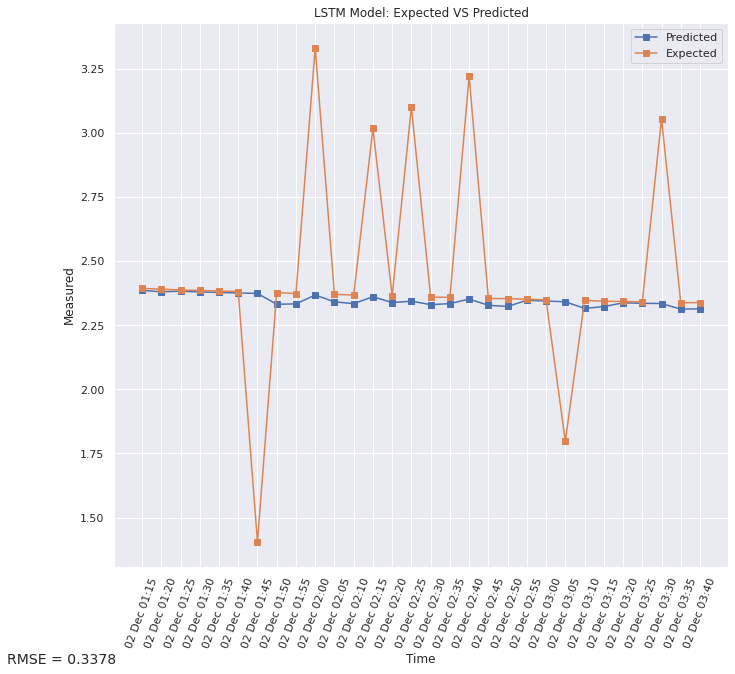

In [23]:
# Plot [start, end] interval
## 0 ~ 11824
start = 300
end = 330
plot_predicted_vs_expected(results["predicted"], results["expected"], results["overall_score"], data.index, start, end)

## Scatter Plot

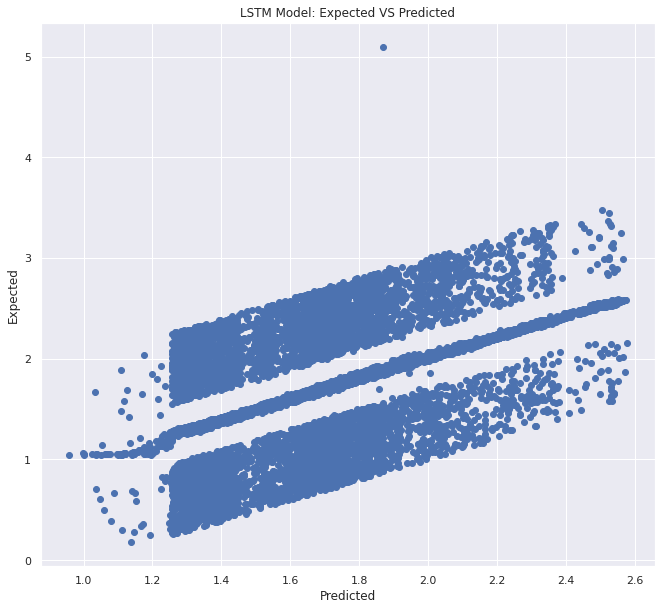

In [24]:
start = 0
end = -1
scatter_plot(results["predicted"], results["expected"], start, end)

## Main - Classification

### 1) Spikes | S


Limit: 0.1393

Spike (S):

  General:
    - TP: 6592
    - TN: 14916
    - FP: 3
    - FN: 5007
    - Hits: 21508
    - Misses: 5010
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 81.11%
    - Precision: 99.95%
    - Recall: 56.83%
    - F1-Score: 72.46%


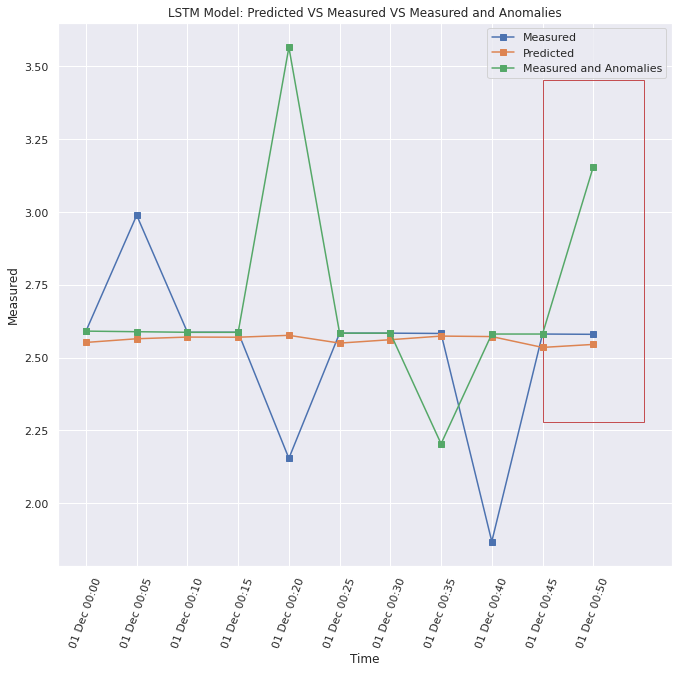

In [25]:
# Read "Spike" data
anomaly_type = "s"
s_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 2) Stationary Values | SV


Limit: 0.1393

Stationary Value (SV):

  General:
    - TP: 3
    - TN: 15421
    - FP: 2
    - FN: 11092
    - Hits: 15424
    - Misses: 11094
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 58.16%
    - Precision: 60.0%
    - Recall: 0.02704%
    - F1-Score: 0.05405%


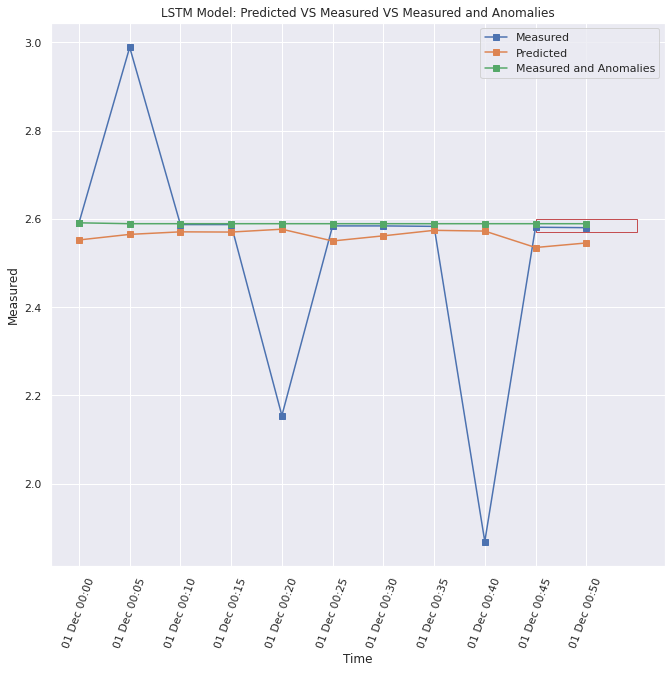

In [26]:
# Read "Stationary Values" data
anomaly_type = "sv"
sv_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 3) Sensor Displacement | SD


Limit: 0.1393

Sensor Displacement (SD):

  General:
    - TP: 6342
    - TN: 14869
    - FP: 4
    - FN: 5303
    - Hits: 21211
    - Misses: 5307
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 79.99%
    - Precision: 99.94%
    - Recall: 54.46%
    - F1-Score: 70.5%


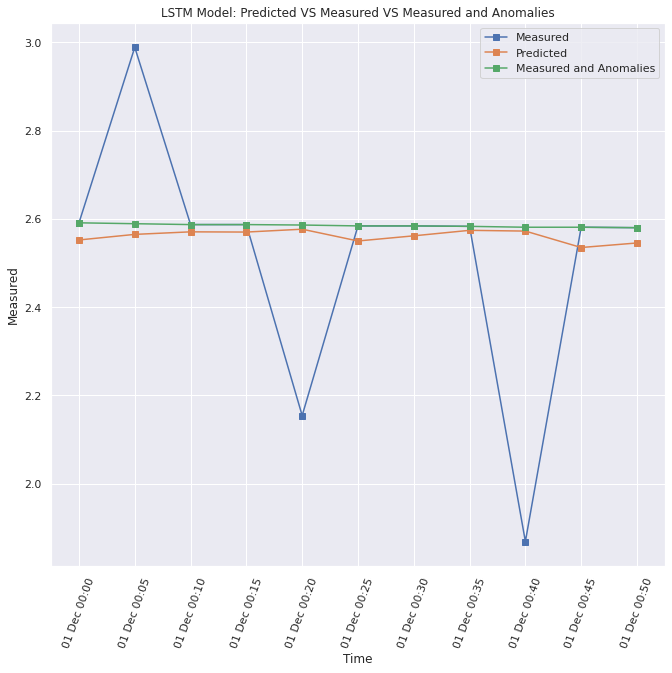

In [27]:
# Read "Sensor Displacement" data
anomaly_type = "sd"
sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 4) S + SV


Limit: 0.1393

Spike (S) and Stationary Value (SV):

  General:
    - TP: 964
    - TN: 15383
    - FP: 5
    - FN: 10166
    - Hits: 16347
    - Misses: 10171
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 61.64%
    - Precision: 99.48%
    - Recall: 8.661%
    - F1-Score: 15.94%


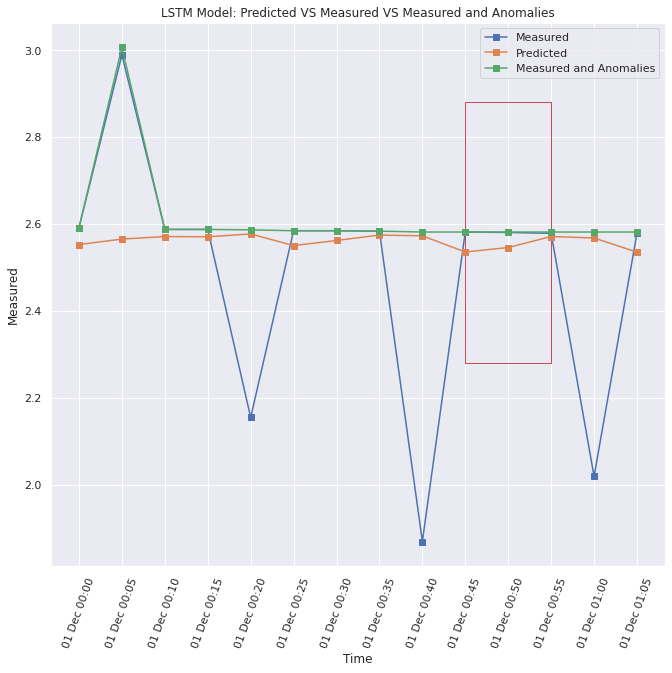

In [28]:
# Read "Spike + Stationary Values" data
anomaly_type = "s+sv"
s_sv_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 5) S + SD


Limit: 0.1393

Spike (S) and Sensor Displacement (SD):

  General:
    - TP: 6328
    - TN: 14951
    - FP: 4
    - FN: 5235
    - Hits: 21279
    - Misses: 5239
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 80.24%
    - Precision: 99.94%
    - Recall: 54.73%
    - F1-Score: 70.72%


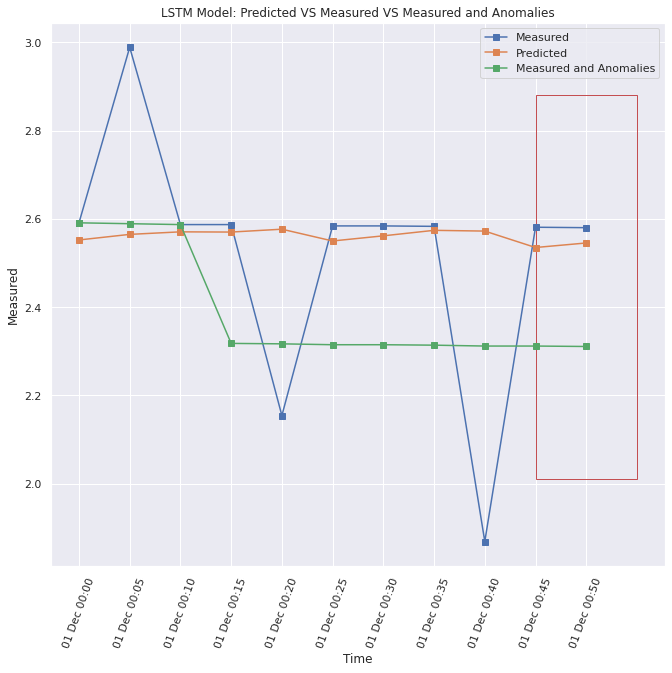

In [29]:
# Read "Spike + Sensor Displacement" data
anomaly_type = "s+sd"
s_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 6) SV + SD


Limit: 0.1393

Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 3151
    - TN: 15238
    - FP: 5
    - FN: 8124
    - Hits: 18389
    - Misses: 8129
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 69.35%
    - Precision: 99.84%
    - Recall: 27.95%
    - F1-Score: 43.67%


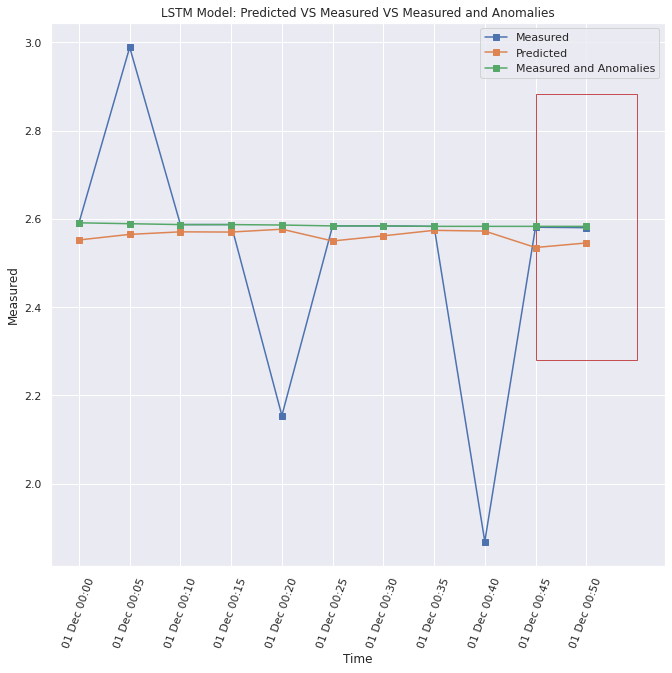

In [30]:
# Read "Stationary Values + Sensor Displacement" data
anomaly_type = "sv+sd"
sv_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 7) S + SV + SD


Limit: 0.1393

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 3382
    - TN: 15171
    - FP: 3
    - FN: 7962
    - Hits: 18553
    - Misses: 7965
    - Total (hits + misses): 26518

  Metrics:
    - Accuracy: 69.96%
    - Precision: 99.91%
    - Recall: 29.81%
    - F1-Score: 45.92%


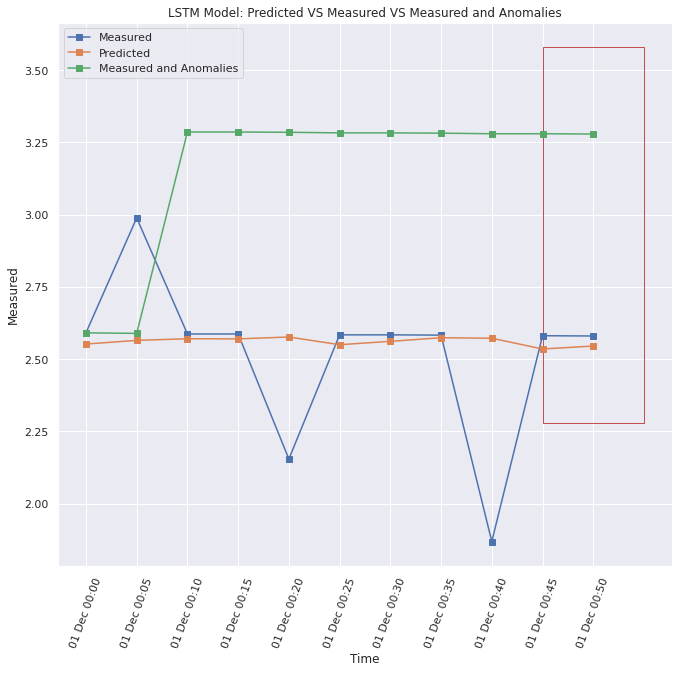

In [31]:
# Read "Spike + Stationary Values + Sensor Displacement" data
anomaly_type = "s+sv+sd"
s_sv_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)